<a href="https://colab.research.google.com/github/KKSTB/COMM061/blob/main/bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys

# If run in colab instead of local
if 'google.colab' in sys.modules:
    # Install any dependencies
    !pip install datasets transformers seqeval evaluate

import datasets
import torch

torch.manual_seed(42)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.3 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=91f9c4251c9a6a535157a8eacaa741881b45f3b96424bad4319808c6ab66b4f0
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:


In [ ]:
datasets_original = datasets.load_dataset('surrey-nlp/PLOD-CW-25')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/268 [00:00<?, ?B/s]

PLOD-CW-25-Train.parquet:   0%|          | 0.00/343k [00:00<?, ?B/s]

PLOD-CW-25-Test.parquet:   0%|          | 0.00/55.5k [00:00<?, ?B/s]

PLOD-CW-25-Val.parquet:   0%|          | 0.00/35.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/250 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/150 [00:00<?, ? examples/s]

In [ ]:
# Extra data from larger dataset
dataset_ext = datasets.load_dataset('surrey-nlp/PLOD-filtered', split=datasets.ReadInstruction('train', to=2000))

README.md:   0%|          | 0.00/7.89k [00:00<?, ?B/s]

PLOD-filtered.py:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/23.7M [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/5.05M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/112652 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/24140 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/24140 [00:00<?, ? examples/s]

In [ ]:
# Need to convert the features in the larger dataset from int to str
def decode_features(entry):
    entry['new_pos_tags'] = [dataset_ext.features['pos_tags'].feature.int2str(tag) for tag in entry['pos_tags']]
    entry['new_ner_tags'] = [dataset_ext.features['ner_tags'].feature.int2str(tag) for tag in entry['ner_tags']]
    entry['new_ner_tags'] = ['O' if tag == 'B-O' else tag for tag in entry['new_ner_tags']]
    return entry

dataset_ext = dataset_ext.map(decode_features)
dataset_ext = dataset_ext.remove_columns(['id', 'pos_tags', 'ner_tags']).rename_columns({'new_pos_tags': 'pos_tags', 'new_ner_tags': 'ner_tags'})

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
# Merge into the original dataset
datasets_original['train'] = datasets.concatenate_datasets([datasets_original['train'], dataset_ext])
datasets_original

DatasetDict({
    train: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 4000
    })
    test: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 250
    })
    validation: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 150
    })
})

In [ ]:
ignore_id = -100

In [ ]:
tag_list = ['O', 'B-AC', 'B-LF', 'I-LF']
tag_id_dict = {k:v for v,k in enumerate(tag_list)}
tag_id_dict_reverse = {v:k for k,v in tag_id_dict.items()}

In [ ]:
tag_cls_dict = {'O': 'O', 'B-AC': 'AC', 'B-LF': 'LF', 'I-LF': 'LF'}
cls_list = dict.fromkeys(tag_cls_dict.values()).keys()
cls_id_dict = {k:v for v,k in enumerate(cls_list)}
cls_id_dict_reverse = {v:k for k,v in cls_id_dict.items()}

In [ ]:
tag_cls_id_dict = {tag_id_dict[k]:cls_id_dict[tag_cls_dict[k]] for k in tag_list}

In [ ]:
n_tags = len(tag_list)
n_cls = len(cls_list)

In [ ]:
tag_colors = {
    'B-AC': 'yellow',
    'B-LF': 'green',
    'I-LF': 'green',
    'AC': 'yellow',
    'LF': 'green',
}

In [ ]:
def convert_ner_tags_to_int(dataset):
    dataset['ner_tag_ids'] = [tag_id_dict[tag] for tag in dataset['ner_tags']]
    return dataset

datasets_original = datasets_original.map(convert_ner_tags_to_int)

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('bert-base-cased') ## We use the BERT tokenizer

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [ ]:
import transformers
assert isinstance(tokenizer, transformers.PreTrainedTokenizerFast)

In [ ]:
label_all_tokens = False

In [ ]:
def tokenize_and_align_tag_ids(dataset):
    tokenized_inputs = tokenizer(dataset['tokens'], truncation=True, is_split_into_words=True)

    all_tokenized_tag_ids = []
    word_idxs = []
    for i, word_tag_ids in enumerate(dataset['ner_tag_ids']):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        tokenized_tag_ids = []
        for word_idx in word_ids:
            # Special tokens(i.e.[CLS],[SEP]) have a word id that is None. We set the label to ignore_id so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                tokenized_tag_ids.append(ignore_id)
            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                tokenized_tag_ids.append(word_tag_ids[word_idx])
            # For the other tokens in a word, we set the label to either the current label or ignore_id, depending on
            # the label_all_tokens flag.
            else:
                tokenized_tag_ids.append(word_tag_ids[word_idx] if label_all_tokens else ignore_id)
            previous_word_idx = word_idx

        all_tokenized_tag_ids.append(tokenized_tag_ids)
        word_idxs.append(word_ids)

    tokenized_inputs['labels'] = all_tokenized_tag_ids
    return tokenized_inputs

In [ ]:
datasets_tokenized = datasets_original.map(tokenize_and_align_tag_ids, batched=True)

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer, DataCollatorForTokenClassification

model = AutoModelForTokenClassification.from_pretrained('bert-base-cased', num_labels=n_tags, label2id=tag_id_dict, id2label=tag_id_dict_reverse, ignore_mismatched_sizes=True)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
args = TrainingArguments(                   ## This is where all your hyperparameters are, reduce *_batch_size if you are working with a GPU which has limited memory.
    'PLOD-ner',
    eval_strategy='epoch',
    save_strategy='epoch',
    learning_rate=1e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=16, # you can change the batch size according to the computational resources
    num_train_epochs=1,   ## may not be enough for a large data, increase this to 5 later in your experiments.
    weight_decay=0.01,
    push_to_hub=False,
    logging_steps=1,
    save_steps=10000,
    report_to='none',
    load_best_model_at_end=True,
    metric_for_best_model='eval_f1',

    #learning_rate is a hyperparameter that controls how quickly the model adapts to the training data. It specifies the size of the step taken at each iteration of the training process in the direction of minimizing the loss. A smaller learning rate results in slower but more precise convergence, while a larger learning rate can lead to faster convergence, but may result in overshooting the optimal solution.
    #per_device_train_batch_size :This parameter specifies how many training examples should be processed together in one forward/backward pass.
    #weight_decay: A regularization term added to the loss function to prevent overfitting. It controls the amount of regularization applied to the weights of the model during training.
    #push_to_hub: A flag that specifies whether to push the trained model to the HuggingFace model hub after training. The model hub is a repository of pre-trained models that can be easily shared and used by the community.
    #eval_steps: The number of training steps between each evaluation of the model on the validation set. This parameter is used to speed up the training process by evaluating the model less frequently.
    #num_train_epochs: The number of times to iterate over the entire training set during training. One epoch means one pass over the entire dataset. Increasing this value may improve the performance of the model, but also increases the training time.



)

In [ ]:
import evaluate
metric = evaluate.load('seqeval')

In [ ]:
import numpy as np

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [tag_list[p] for (p, l) in zip(prediction, label) if l != ignore_id]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [tag_list[l] for (p, l) in zip(prediction, label) if l != ignore_id]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        'precision': results['overall_precision'],
        'recall': results['overall_recall'],
        'f1': results['overall_f1'],
        'accuracy': results['overall_accuracy'],
    }

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=datasets_tokenized['train'],
    eval_dataset=datasets_tokenized['validation'],
    data_collator=DataCollatorForTokenClassification(tokenizer),
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.232400,0.290566,0.704900,0.777641,0.739486,0.902565


TrainOutput(global_step=125, training_loss=0.39897787356376646, metrics={'train_runtime': 142.202, 'train_samples_per_second': 28.129, 'train_steps_per_second': 0.879, 'total_flos': 428779399752960.0, 'train_loss': 0.39897787356376646, 'epoch': 1.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.29056626558303833,
 'eval_precision': 0.7048997772828508,
 'eval_recall': 0.7776412776412777,
 'eval_f1': 0.7394859813084111,
 'eval_accuracy': 0.9025649566955363,
 'eval_runtime': 1.3741,
 'eval_samples_per_second': 109.161,
 'eval_steps_per_second': 7.277,
 'epoch': 1.0}

In [ ]:
predictions, labels, _ = trainer.predict(datasets_tokenized['test'])
predictions = np.argmax(predictions, axis=2)

# Remove ignored index (special tokens)
true_predictions = [
    [tag_list[p] for (p, l) in zip(prediction, label) if l != ignore_id]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [tag_list[l] for (p, l) in zip(prediction, label) if l != ignore_id]
    for prediction, label in zip(predictions, labels)
]

results = metric.compute(predictions=true_predictions, references=true_labels)
results

{'AC': {'precision': np.float64(0.8167281672816729),
  'recall': np.float64(0.8331242158092849),
  'f1': np.float64(0.8248447204968945),
  'number': np.int64(797)},
 'LF': {'precision': np.float64(0.5892255892255892),
  'recall': np.float64(0.7261410788381742),
  'f1': np.float64(0.6505576208178439),
  'number': np.int64(482)},
 'overall_precision': np.float64(0.720682302771855),
 'overall_recall': np.float64(0.7928068803752932),
 'overall_f1': np.float64(0.7550260610573343),
 'overall_accuracy': 0.9189821585258847}

In [ ]:
# Remove ignored index (special tokens)
true_cls = [
    [tag_cls_id_dict[l] for (p, l) in zip(prediction, label) if l != ignore_id]
    for prediction, label in zip(predictions, labels)
]
pred_cls = [
    [tag_cls_id_dict[p] for (p, l) in zip(prediction, label) if l != ignore_id]
    for prediction, label in zip(predictions, labels)
]

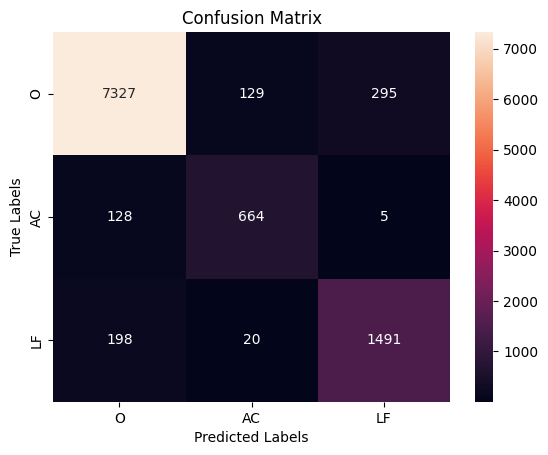

In [ ]:
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

cm = np.zeros((n_cls, n_cls), dtype=int)
for y_true, y_pred in zip(true_cls, pred_cls):
    cm += metrics.confusion_matrix(y_true, y_pred, labels=tuple(range(n_cls)))

# Plot the confusion matrix using seaborn
plt.figure()
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(np.arange(n_cls)+0.5, cls_list)
plt.yticks(np.arange(n_cls)+0.5, cls_list)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Remove ignored index (special tokens)
true_tag_ids = [
    [int(l) for (p, l) in zip(prediction, label) if l != ignore_id]
    for prediction, label in zip(predictions, labels)
]
pred_tag_ids = [
    [int(p) for (p, l) in zip(prediction, label) if l != ignore_id]
    for prediction, label in zip(predictions, labels)
]

In [ ]:
import spacy
from spacy import displacy


def display_named_entity(idx, dataset, tag_ids):
    doc = spacy.blank('en')(' '.join(dataset['tokens'][idx]))

    char_cnt = 0
    prev_char_cnt = 0
    prev_tag_id = 0
    start_char_cnt = -1
    was_wrong = False
    ents = []
    for token, tag_id in zip(dataset['tokens'][idx], tag_ids[idx]):
        token_len = len(token)
        tag = tag_id_dict_reverse[tag_id]
        if tag.startswith('I'):
            # Check whether it is continued from the same class as the previous
            if tag_cls_id_dict[tag_id] != tag_cls_id_dict[prev_tag_id]:
                # Not the same class (the model made the wrong prediction)
                if prev_tag_id != 0:
                    if was_wrong:
                        ents.append(doc.char_span(start_char_cnt, prev_char_cnt, tag_id_dict_reverse[prev_tag_id]))
                    else:
                        ents.append(doc.char_span(start_char_cnt, prev_char_cnt, cls_id_dict_reverse[tag_cls_id_dict[prev_tag_id]]))
                start_char_cnt = char_cnt
                was_wrong = True
        elif tag.startswith('B'):
            # B tag
            if prev_tag_id == 0:
                # Begins from O tag
                pass
            else:
                # Begins from a different B tag
                if was_wrong:
                    ents.append(doc.char_span(start_char_cnt, prev_char_cnt, tag_id_dict_reverse[prev_tag_id]))
                else:
                    ents.append(doc.char_span(start_char_cnt, prev_char_cnt, cls_id_dict_reverse[tag_cls_id_dict[prev_tag_id]]))
            start_char_cnt = char_cnt
            was_wrong = False
        else:
            # O tag
            if prev_tag_id != 0:
                if was_wrong:
                    ents.append(doc.char_span(start_char_cnt, prev_char_cnt, tag_id_dict_reverse[prev_tag_id]))
                else:
                    ents.append(doc.char_span(start_char_cnt, prev_char_cnt, cls_id_dict_reverse[tag_cls_id_dict[prev_tag_id]]))
        prev_tag_id = tag_id
        prev_char_cnt = char_cnt + token_len
        char_cnt += token_len + 1

    if prev_tag_id != 0:
        # Case where the sentence ends with non-O tag
        if was_wrong:
            ents.append(doc.char_span(start_char_cnt, prev_char_cnt, tag_id_dict_reverse[prev_tag_id]))
        else:
            ents.append(doc.char_span(start_char_cnt, prev_char_cnt, cls_id_dict_reverse[tag_cls_id_dict[prev_tag_id]]))

    doc.ents = ents

    displacy.render(doc, style='ent', options={'colors': tag_colors})

In [ ]:
import spacy
from spacy import displacy


def display_named_entity_raw(idx, dataset, tag_ids):
    doc = spacy.blank('en')(' '.join(dataset['tokens'][idx]))

    char_cnt = 0
    prev_char_cnt = 0
    prev_tag_id = 0
    start_char_cnt = -1
    ents = []
    for token, tag_id in zip(dataset['tokens'][idx], tag_ids[idx]):
        token_len = len(token)
        if tag_id != 0:
            if prev_tag_id != tag_id:
                if prev_tag_id != 0:
                    ents.append(doc.char_span(start_char_cnt, prev_char_cnt, tag_id_dict_reverse[prev_tag_id]))
                start_char_cnt = char_cnt
        else:
            if prev_tag_id != tag_id and prev_tag_id != 0:
                ents.append(doc.char_span(start_char_cnt, prev_char_cnt, tag_id_dict_reverse[prev_tag_id]))
        prev_tag_id = tag_id
        prev_char_cnt = char_cnt + token_len
        char_cnt += token_len + 1

    if prev_tag_id != 0:
        # Case where the sentence ends with non-O tag
        ents.append(doc.char_span(start_char_cnt, prev_char_cnt, tag_id_dict_reverse[prev_tag_id]))

    doc.ents = ents

    displacy.render(doc, style='ent', options={'colors': tag_colors})

In [ ]:
import spacy
from spacy import displacy


def diff_named_entity(idx, dataset, true_tag_ids, pred_tag_ids):
    doc = spacy.blank('en')(' '.join(dataset['tokens'][idx]))

    char_cnt = prev_char_cnt = 0
    prev_pred_tag_id = 0
    start_char_cnt = -1
    was_wrong = False
    ents = []
    for token, true_tag_id, pred_tag_id in zip(dataset['tokens'][idx], true_tag_ids[idx], pred_tag_ids[idx]):
        token_len = len(token)
        if true_tag_id != pred_tag_id:
            # The model made the wrong prediction
            # Highlight everything wrong
            if was_wrong:
                # Highlight everything different
                if prev_pred_tag_id != pred_tag_id:
                    ents.append(doc.char_span(start_char_cnt, prev_char_cnt, '(' + tag_id_dict_reverse[prev_pred_tag_id] + ')'))
                    start_char_cnt = char_cnt
            else:
                if prev_pred_tag_id != 0:
                    ents.append(doc.char_span(start_char_cnt, prev_char_cnt, cls_id_dict_reverse[tag_cls_id_dict[prev_pred_tag_id]]))
                start_char_cnt = char_cnt
                was_wrong = True
        else:
            # The model made the correct prediction
            if was_wrong:
                ents.append(doc.char_span(start_char_cnt, prev_char_cnt, '(' + tag_id_dict_reverse[prev_pred_tag_id] + ')'))
                start_char_cnt = char_cnt
                was_wrong = False
            else:
                # Highlight by cls of predition
                if tag_cls_id_dict[pred_tag_id] != tag_cls_id_dict[prev_pred_tag_id]:
                    if prev_pred_tag_id != 0:
                        ents.append(doc.char_span(start_char_cnt, prev_char_cnt, cls_id_dict_reverse[tag_cls_id_dict[prev_pred_tag_id]]))
                    start_char_cnt = char_cnt
        prev_pred_tag_id = pred_tag_id
        prev_char_cnt = char_cnt + token_len
        char_cnt += token_len + 1

    if prev_pred_tag_id != 0:
        # Case where the sentence ends with non-O tag
        if was_wrong:
            ents.append(doc.char_span(start_char_cnt, prev_char_cnt, '(' + tag_id_dict_reverse[prev_pred_tag_id] + ')'))
        else:
            ents.append(doc.char_span(start_char_cnt, prev_char_cnt, cls_id_dict_reverse[tag_cls_id_dict[prev_pred_tag_id]]))

    doc.ents = ents

    err_tag_colors = tag_colors | {'('+k+')':'red' for k in tag_colors.keys()} | {'(O)':'red'}
    displacy.render(doc, style='ent', options={'colors': err_tag_colors})

In [ ]:
idx = 15
display_named_entity(idx, datasets_tokenized['test'], true_tag_ids)
print()
display_named_entity(idx, datasets_tokenized['test'], pred_tag_ids)
print()
diff_named_entity(idx, datasets_tokenized['test'], true_tag_ids, pred_tag_ids)